In [1]:
import os
import math
import pandas as pd
from pipeline.data_processing import DatasetManager, AudioProcessing
from pipeline.data_augmentation import DataAugmentation
from pipeline.feature_extraction import FeatureDatasetManager

## 1. Data Processing


Vowel dataset stats:

  diagnosis     sex  mean_duration  std_duration  max_duration  sample_count  \
0    health  female       1.309741      0.440195       4.39002           428   
1    health    male       1.322894      0.389546       2.30174           259   
2      path  female       1.276132      0.462773       2.47746           727   
3      path    male       1.269985      0.472415       2.63310           627   

   mean_pitch   std_pitch    max_pitch  
0  509.268677  312.352173  1104.998047  
1  481.744141  248.938828   861.363586  
2  378.948669  281.308960  1400.936279  
3  399.602020  275.603485  1196.130493  

Phrase dataset stats:

  diagnosis     sex  mean_duration  std_duration  max_duration  sample_count  \
0    health  female       1.840343      0.358211       4.14034           382   
1    health    male       1.869465      0.387643       3.90320           252   
2      path  female       2.329902      0.623793       6.35934           726   
3      path    male       2

AttributeError: 'str' object has no attribute 'shape'

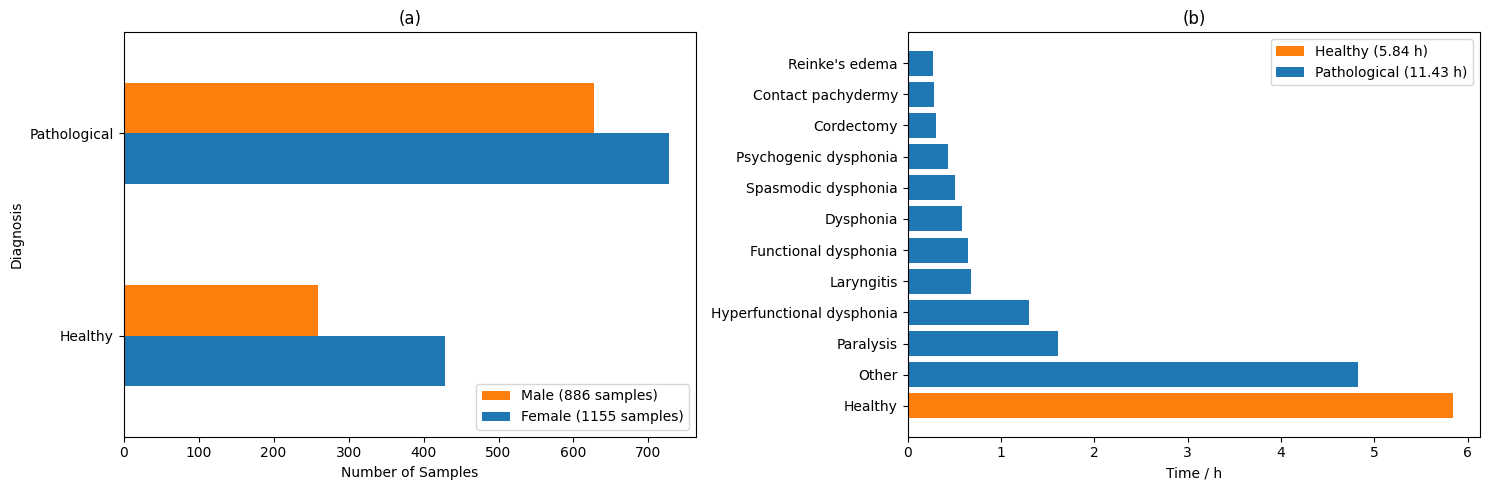

In [9]:
dm = DatasetManager('data/svd')
vowel_dataset, phrase_dataset = dm.create_dataset()
dm.plot_dataset_distribution(vowel_dataset, os.path.join('data', 'distribution_pathologies.json'), os.path.join('images', 'dataset_distribution.png'))

# Extract statistics from dataset
vowel_dataset_stats = dm.analyse_dataset(vowel_dataset)
phrase_dataset_stats = dm.analyse_dataset(phrase_dataset)
print('\nVowel dataset stats:\n')
print(vowel_dataset_stats)
print('\nPhrase dataset stats:\n')
print(phrase_dataset_stats)

# Align dataset 
vowel_dataset, phrase_dataset = dm.align_dataset(vowel_dataset, phrase_dataset)

# Resample audios
target_sample_rate = 16000
vowel_dataset.loc[:, 'audio_data'] = AudioProcessing.resample_all_audios(vowel_dataset['audio_data'], vowel_dataset['sample_rate'], target_sample_rate)
phrase_dataset.loc[:, 'audio_data'] = AudioProcessing.resample_all_audios(phrase_dataset['audio_data'], phrase_dataset['sample_rate'], target_sample_rate)
vowel_dataset.loc[:, 'sample_rate'] = target_sample_rate
phrase_dataset.loc[:, 'sample_rate'] = target_sample_rate

# Might be moved to utilites class
def round_up_to_half(number):
    """
    Rounds a float up to the nearest multiple of 0.5.
    
    Args:
    number (float): The number to round.

    Returns:
    float: The number rounded up to the nearest 0.5.
    """
    return math.ceil(number * 2) / 2

# Pad audios 
vowel_dataset_stats = dm.analyse_dataset(vowel_dataset)
phrase_dataset_stats = dm.analyse_dataset(phrase_dataset)
vowel_target_duration = round_up_to_half(max(vowel_dataset_stats['max_duration']))
phrase_target_duration = round_up_to_half(max(phrase_dataset_stats['max_duration']))
vowel_dataset.loc[:, 'audio_data'] = AudioProcessing.pad_audios(vowel_dataset['audio_data'], vowel_dataset['sample_rate'], vowel_target_duration)
phrase_dataset.loc[:, 'audio_data'] = AudioProcessing.pad_audios(phrase_dataset['audio_data'], phrase_dataset['sample_rate'], phrase_target_duration)
DatasetManager.save_all_audios(vowel_dataset['audio_data'], vowel_dataset['sample_rate'], vowel_dataset['audio_path'])
DatasetManager.save_all_audios(phrase_dataset['audio_data'], phrase_dataset['sample_rate'], phrase_dataset['audio_path'])

# Save datasets
DatasetManager.save_dataset(vowel_dataset, os.path.join('datasets', 'processed', 'vowel_dataset.csv'))
DatasetManager.save_dataset(phrase_dataset, os.path.join('datasets', 'processed', 'phrase_dataset.csv'))

# Extract statistics from dataset
vowel_dataset_stats = dm.analyse_dataset(vowel_dataset)
phrase_dataset_stats = dm.analyse_dataset(phrase_dataset)
print('\nVowel dataset stats:\n')
print(vowel_dataset_stats)
print('\nPhrase dataset stats:\n')
print(phrase_dataset_stats)

## 2. Data Augmentation

In [7]:
'''
As the dataset shows inherent imbalances, this section will augment audio data to ensure a balances set.
This is done by one of three methods:
- Adding white noise
- Pitch shifting the audio
- Time strechting the audio

As vowel and phrase entries are already alignes, either one of these options creates a new dataset entry in both the vowel and phrase dataset. 
To ensure a good overview, the augmented data will be markes via the additon of "_augmented" at the end of the audio path.

For each augmentation, the passed augmentation type is applied to a randomly selected audio from the passed datasets. Not the full datasets are passed, 
but only the category and/or sex to be augmented. This way, the dataset can be balanced out, while still giving the user enough control and overviwe of the process.

Another option to consider would be the following:
The user can not specifically decide which augmentation type is used, but the augmentation parameters can be set. 
The augmentation type will be selected by taking turns, ensuring each augmentation type is represented equally.
'''
print(vowel_dataset['audio_data'])

vowel_dataset_stats = dm.analyse_dataset(vowel_dataset)
phrase_dataset_stats = dm.analyse_dataset(phrase_dataset)

## Health male -> 
# 498 samples to augment
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'health')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'health')],
    aug_type='noise',
    n_audios=249,
    noise_level=0.05
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'health')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'health')],
    aug_type='stretch',
    n_audios=249,
    noise_level=0.9
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)

##  Health female
# -> 368 samples to augment
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    aug_type='noise',
    n_audios=184,
    noise_level=0.05
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    aug_type='stretch',
    n_audios=184,
    noise_level=0.9
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)

## Path male 
# 113 samples to augment
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'path')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'path')],
    vowel_stats=vowel_dataset_stats,
    phrase_stats=phrase_dataset_stats,
    aug_type='noise',
    n_audios=56,
    noise_level=0.05
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'path')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'male') & (vowel_dataset['diagnosis'] == 'path')],
    vowel_stats=vowel_dataset_stats,
    phrase_stats=phrase_dataset_stats,
    aug_type='stretch',
    n_audios=57,
    stretch_rate=0.9
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)

## Path male 
# 24 samples to augment
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'path')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'path')],
    vowel_stats=vowel_dataset_stats,
    phrase_stats=phrase_dataset_stats,
    aug_type='noise',
    n_audios=12,
    noise_level=0.05
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)
aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'path')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'path')],
    vowel_stats=vowel_dataset_stats,
    phrase_stats=phrase_dataset_stats,
    aug_type='stretch',
    n_audios=12,
    stretch_rate=0.9
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)

'''
## PROBLEM
# Problem with pitch shift: If labels are updated (in chase the pitch afterwards sounds more like another sex), 
# the sit will very likely be inbalanced as well. This would necessitate a sort of regularization algorithm, 
# to delete augmented audios in the sex subcategory to which the pitch shifted audio is moved.
# Probably to eleborate for now, so pitch_shift will not be supported for now.

aug_vowel_dataset, aug_phrase_dataset = DataAugmentation.augment_audio(
    vowel_dataset=vowel_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    phrase_dataset=phrase_dataset[(vowel_dataset['sex'] == 'female') & (vowel_dataset['diagnosis'] == 'health')],
    vowel_stats=vowel_dataset_stats,
    phrase_stats=phrase_dataset_stats,
    aug_type='pitch',
    n_audios=100,
    shift_steps=2.0
)
vowel_dataset = pd.concat([vowel_dataset, aug_vowel_dataset], ignore_index=True)
phrase_dataset = pd.concat([phrase_dataset, aug_phrase_dataset], ignore_index=True)
'''


# Extract statistics from dataset
vowel_dataset_stats = dm.analyse_dataset(vowel_dataset)
phrase_dataset_stats = dm.analyse_dataset(phrase_dataset)
print('\nVowel dataset stats:\n')
print(vowel_dataset_stats)
print('\nPhrase dataset stats:\n')
print(phrase_dataset_stats)

print(vowel_dataset)
print(phrase_dataset)

0       [0.10308273881673813, 0.15723803639411926, 0.0...
1       [-0.044552914798259735, -0.0923934131860733, -...
2       [-0.15464694797992706, -0.1381075531244278, 0....
3       [-0.019945476204156876, -0.02346813678741455, ...
4       [0.036596789956092834, 0.07159580290317535, 0....
                              ...                        
1982    [-0.016421860083937645, -0.04554981365799904, ...
1983    [-0.04787220060825348, -0.08667315542697906, -...
1984    [-0.1081051304936409, -0.2265045940876007, -0....
1985    [-0.014063174836337566, -0.038980480283498764,...
1986    [0.08717159926891327, 0.1491263508796692, 0.12...
Name: audio_data, Length: 1987, dtype: object


KeyboardInterrupt: 

## 3. Feature Extraction

In [ ]:
# TODO: Calculate padsize 

vowel_feature_dataset, phrase_feature_dataset = FeatureDatasetManager.create_dataset(
    vowel_dataset=vowel_dataset,
    phrase_dataset=phrase_dataset,
    padsize_mfcc=300,
    padsize_wav2vec2=300
)

In [ ]:
import numpy as np

# Convert to numpy arrays
vowel_mfcc_featureset = np.array([np.array(x) for x in vowel_feature_dataset['mfcc']]) # Shape: (2031, 13, 500)
f0_featureset = np.array([np.array(x) for x in vowel_feature_dataset['f0']]) # Shape: (2031, )
jitter_featureset = np.array([np.array(x) for x in vowel_feature_dataset['jitter']]) # Shape: (2031, )
shimmer_featureset = np.array([np.array(x) for x in vowel_feature_dataset['shimmer']]) # Shape: (2031, )
sex_featureset = np.array([np.array(x) for x in vowel_feature_dataset['sex']]) # Shape: (2031, )
phrase_mfcc_featureset = np.array([np.array(x) for x in phrase_feature_dataset['mfcc']]) # Shape: (2031, 13, 500)
# wav2vec2_featureset = np.array([np.array(x) for x in phrase_feature_dataset['wav2vec2']]) # Shape: (2031, 12, 500, 768)
diagnosis_featureset = np.array([np.array(x) for x in phrase_feature_dataset['diagnosis']]) # Shape: (2031, )

## 4. Classification

### 4.1 Vowel Model

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_lstm_model(vowel_feature_dataset, epochs=50, batch_size=32):
    # Extract MFCC features and the target labels
    mfcc_featureset_vowel = np.array([np.array(x) for x in vowel_feature_dataset['mfcc']])
    diagnosis_featureset = np.array([np.array(x) for x in vowel_feature_dataset['diagnosis']])

    # Reshape mfcc features
    mfcc_featureset_vowel_shape = mfcc_featureset_vowel.shape
    X = mfcc_featureset_vowel.transpose(0, 2, 1, 3).reshape(mfcc_featureset_vowel_shape[0], mfcc_featureset_vowel_shape[2], mfcc_featureset_vowel_shape[1] * mfcc_featureset_vowel_shape[3])
    y = diagnosis_featureset

    # scaler = StandardScaler()
    # mfcc_featureset_vowel_scaled = scaler.fit_transform(mfcc_featureset_vowel_reshaped).reshape(num_samples, num_features, num_frames)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and compile the LSTM model
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(mfcc_featureset_vowel_shape[2], mfcc_featureset_vowel_shape[1] * mfcc_featureset_vowel_shape[3])),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    return model, history, loss, accuracy

# Example usage:
model, history, loss, accuracy = train_lstm_model(vowel_feature_dataset)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def train_svm_model(vowel_feature_dataset, lstm_features_train, lstm_features_test, epochs=25, batch_size=32):
    # Extract and process features
    def process_features(dataset, feature):
        return np.array([np.array(x) for x in dataset[feature]])

    f0_featureset = process_features(vowel_feature_dataset, 'f0').flatten()
    jitter_featureset = process_features(vowel_feature_dataset, 'jitter').flatten()
    # shimmer_featureset = process_features(vowel_feature_dataset, 'shimmer').flatten()
    sex_featureset = process_features(vowel_feature_dataset, 'sex')
    diagnosis_featureset = process_features(vowel_feature_dataset, 'diagnosis')

    # Standardize the continuous features
    scaler = StandardScaler()
    f0_featureset = scaler.fit_transform(f0_featureset.reshape(-1, 1)).flatten()
    jitter_featureset = scaler.fit_transform(jitter_featureset.reshape(-1, 1)).flatten()
    # shimmer_featureset = scaler.fit_transform(shimmer_featureset.reshape(-1, 1)).flatten()

    # Combine all features
    X = np.hstack([f0_featureset.reshape(-1, 1), jitter_featureset.reshape(-1, 1), sex_featureset.reshape(-1, 1)])
    y = diagnosis_featureset
    X_train_svm, X_test_svm, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    combined_features_train = np.concatenate((lstm_features_train, X_train_svm), axis=1)
    combined_features_test = np.concatenate((lstm_features_test, X_test_svm), axis=1)

    # Train SVM
    svm_model = SVC(kernel='linear')
    svm_model.fit(combined_features_train, y_train)

    # Predict and evaluate
    y_pred = svm_model.predict(combined_features_test)

    '''
    # Define and compile the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    '''

    # return model, history, loss, accuracy

# Example usage:
feature_extractor = model(inputs=lstm_model.input, outputs=lstm_model.layers[-2].output)
lstm_features_train = feature_extractor.predict(X_train_lstm)
lstm_features_test = feature_extractor.predict(X_test_lstm)

model, history, loss, accuracy = train_svm_model(vowel_feature_dataset)

In [44]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def extract_mfcc_features(vowel_feature_dataset):
    mfcc_featureset_vowel = np.array([np.array(x) for x in vowel_feature_dataset['mfcc']])
    diagnosis_featureset = np.array([np.array(x) for x in vowel_feature_dataset['diagnosis']])
    return mfcc_featureset_vowel, diagnosis_featureset

def preprocess_mfcc_features(mfcc_featureset_vowel):
    mfcc_featureset_vowel_shape = mfcc_featureset_vowel.shape
    X = mfcc_featureset_vowel.transpose(0, 2, 1, 3).reshape(
        mfcc_featureset_vowel_shape[0], 
        mfcc_featureset_vowel_shape[2], 
        mfcc_featureset_vowel_shape[1] * mfcc_featureset_vowel_shape[3]
    )
    return X

def train_lstm_model(vowel_feature_dataset, epochs=50, batch_size=32):
    # Extract MFCC features and the target labels
    mfcc_featureset_vowel, y = extract_mfcc_features(vowel_feature_dataset)
    X = preprocess_mfcc_features(mfcc_featureset_vowel)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and compile the LSTM model
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    return model, history, loss, accuracy, X_train, X_test

def process_features(dataset, feature):
    return np.array([np.array(x) for x in dataset[feature]])

def extract_svm_features(vowel_feature_dataset):
    f0_featureset = process_features(vowel_feature_dataset, 'f0').flatten()
    jitter_featureset = process_features(vowel_feature_dataset, 'jitter').flatten()
    sex_featureset = process_features(vowel_feature_dataset, 'sex')
    diagnosis_featureset = process_features(vowel_feature_dataset, 'diagnosis')
    return f0_featureset, jitter_featureset, sex_featureset, diagnosis_featureset

def scale_features(f0_featureset, jitter_featureset):
    scaler = StandardScaler()
    f0_featureset = scaler.fit_transform(f0_featureset.reshape(-1, 1)).flatten()
    jitter_featureset = scaler.fit_transform(jitter_featureset.reshape(-1, 1)).flatten()
    return f0_featureset, jitter_featureset

def train_svm_model(vowel_feature_dataset, lstm_features_train, lstm_features_test):
    # Extract and process features
    f0_featureset, jitter_featureset, sex_featureset, y = extract_svm_features(vowel_feature_dataset)
    f0_featureset, jitter_featureset = scale_features(f0_featureset, jitter_featureset)

    # Combine all features
    X = np.hstack([f0_featureset.reshape(-1, 1), jitter_featureset.reshape(-1, 1), sex_featureset.reshape(-1, 1)])
    X_train_svm, X_test_svm, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    combined_features_train = np.concatenate((lstm_features_train, X_train_svm), axis=1)
    combined_features_test = np.concatenate((lstm_features_test, X_test_svm), axis=1)

    # Train SVM
    svm_model = SVC(kernel='linear')
    svm_model.fit(combined_features_train, y_train)

    # Predict and evaluate
    y_pred = svm_model.predict(combined_features_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    return svm_model

model, history, loss, accuracy, X_train, X_test = train_lstm_model(vowel_feature_dataset)

# Extract LSTM features
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
lstm_features_train = feature_extractor.predict(X_train)
lstm_features_test = feature_extractor.predict(X_test)

svm_model = train_svm_model(vowel_feature_dataset, lstm_features_train, lstm_features_test)

ValueError: axes don't match array

### 4.2 Phrase Model